# Latent Neural ODEs — Irregular Time Series Lab
**Learning objectives**
- Implement the variational latent ODE where $q_\phi(z_0 \mid \{x_t, t_t\})$ infers an initial latent state and $\dot{z} = f_\theta(z, t)$ describes its dynamics
- Reproduce the Archimedean spiral dataset used in `torchdiffeq/examples/latent_ode.py`
- Train an ODE-RNN encoder + Neural ODE decoder pair that handles irregular samples
- Compare posterior sampling, interpolation, and extrapolation to understand how the latent space behaves


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/08-neural-ode/latent-ode.ipynb)

## 1. Why latent ODEs?
Regular Neural ODEs assume dense, regularly sampled trajectories with known initial states. The latent ODE treats each sequence as a sample from a continuous-time VAE:
1. Sample $z_0 \sim \mathcal{N}(0, I)$.
2. Evolve $z(t)$ by solving $\dot{z} = f_\theta(z, t)$, so $z(t) = z_0 + \int_{t_0}^{t} f_\theta(z(\tau), \tau)\,d\tau$.
3. Decode each latent state with $p_\psi(x_t \mid z_t) = \mathcal{N}(g_\psi(z_t), \sigma^2 I)$ to obtain observations.
4. Use an ODE-RNN encoder $q_\phi(z_0 \mid \{x_t, t_t\})$ that scans the irregular samples backward in time to amortize inference.

This mirrors the course style from the PINNs/DeepONet modules: intuition first, implementation next, experiments last.


## 2. Environment setup


In [3]:
!pip3 install torchdiffeq


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import math
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint, odeint_adjoint

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'axes.grid': True, 'figure.figsize': (6, 4)})

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cpu')

In [5]:
def set_seed(seed=42):
    np.random.seed(seed)
    npr.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)


## 3. Generate the spiral dataset
We reuse the exact data generator from `torchdiffeq/examples/latent_ode.py`: two Archimedean spirals whose radius obeys $r(\theta) = a + b\theta$ (counter-clockwise) or $r(\theta) = a + \frac{50b}{\theta_{\max}+1-\theta}$ (clockwise). Random start indices and additive Gaussian noise make the observations irregular and challenging. Each trajectory contains the full underlying path `orig_trajs`; the model only sees noisy snippets `samp_trajs` with associated timestamps `samp_ts`.


In [6]:
def generate_spiral_dataset(nspiral=512, ntotal=1000, nsample=100,
                            start=0.0, stop=6 * np.pi, noise_std=0.3,
                            a=0.0, b=0.3):
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    zs_cw = stop + 1.0 - orig_ts
    rs_cw = a + b * 50.0 / zs_cw
    cw = np.stack((rs_cw * np.cos(zs_cw) - 5.0, rs_cw * np.sin(zs_cw)), axis=1)

    zs_cc = orig_ts
    rs_cc = a + b * zs_cc
    cc = np.stack((rs_cc * np.cos(zs_cc) + 5.0, rs_cc * np.sin(zs_cc)), axis=1)

    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        t0_idx = npr.randint(nsample, ntotal - nsample)
        template = cc if npr.rand() > 0.5 else cw
        orig_trajs.append(template)
        window = template[t0_idx:t0_idx + nsample, :].copy()
        window += npr.randn(*window.shape) * noise_std
        samp_trajs.append(window)

    return (
        np.stack(orig_trajs, axis=0),
        np.stack(samp_trajs, axis=0),
        orig_ts,
        samp_ts,
    )

orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral_dataset()
orig_trajs.shape, samp_trajs.shape


((512, 1000, 2), (512, 100, 2))

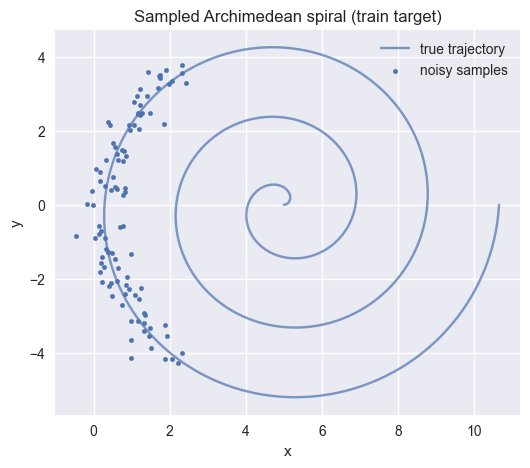

In [7]:
def plot_spirals(orig, samples):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(orig[0, :, 0], orig[0, :, 1], label='true trajectory', alpha=0.7)
    ax.scatter(samples[0, :, 0], samples[0, :, 1], s=10, label='noisy samples')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_title('Sampled Archimedean spiral (train target)')
    plt.show()

plot_spirals(orig_trajs, samp_trajs)


## 4. Preparing tensors and mini-batches
We treat every trajectory as a batch element (no shuffling for simplicity). The recognition network consumes observations in reverse chronological order, matching the ODE-RNN design that conditions on future information when inferring $z_0$.


In [8]:
orig_trajs = torch.from_numpy(orig_trajs).float().to(DEVICE)
samp_trajs = torch.from_numpy(samp_trajs).float().to(DEVICE)
samp_ts = torch.from_numpy(samp_ts).float().to(DEVICE)
orig_ts = torch.from_numpy(orig_ts).float().to(DEVICE)

BATCH = samp_trajs.shape[0]
obs_dim = samp_trajs.shape[-1]
print('BATCH', BATCH, 'obs dim', obs_dim)


BATCH 512 obs dim 2


## 5. Model components
We implement the three learnable blocks required by the latent-ODE architecture:
- `LatentODEFunc`: latent vector field $f_\theta$.
- `EncoderRNN`: ODE-RNN recognition model that outputs mean/log-variance of $q(z_0 \mid \{x_t\})$.
- `Decoder`: likelihood model $p(x_t \mid z_t)$ (Gaussian with fixed variance).

Initialization mirrors the official implementation but with clearer modules for notebook readability.


In [9]:
class LatentODEFunc(nn.Module):
    def __init__(self, latent_dim=6, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim, latent_dim),
        )
        self.nfe = 0

    def forward(self, t, z):
        self.nfe += 1
        return self.net(z)


class EncoderRNN(nn.Module):
    def __init__(self, latent_dim=6, obs_dim=2, hidden_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.i2h = nn.Linear(obs_dim + hidden_dim, hidden_dim)
        self.h2out = nn.Linear(hidden_dim, 2 * latent_dim)

    def forward(self, obs_seq):
        h = torch.zeros(obs_seq.size(0), self.hidden_dim, device=obs_seq.device)
        for t in reversed(range(obs_seq.size(1))):
            obs = obs_seq[:, t, :]
            inp = torch.cat([obs, h], dim=-1)
            h = torch.tanh(self.i2h(inp))
        stats = self.h2out(h)
        mean, logvar = torch.chunk(stats, 2, dim=-1)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=6, obs_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, obs_dim)
        )

    def forward(self, z):
        return self.net(z)


## 6. Variational helpers


In [10]:
def reparameterize(mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std


def log_normal_pdf(x, mean, logvar):
    return -0.5 * (np.log(2 * np.pi) + logvar + (x - mean) ** 2 / torch.exp(logvar))


def normal_kl(mean1, logvar1, mean2, logvar2):
    v1 = torch.exp(logvar1)
    v2 = torch.exp(logvar2)
    return 0.5 * (logvar2 - logvar1 + (v1 + (mean1 - mean2) ** 2) / v2 - 1.0)


## 7. ELBO objective
The training signal is the negative evidence lower bound
$$\mathcal{L}_{\text{ELBO}} = -\mathbb{E}_{q_\phi(z_0 \mid x_{1:T})}\Big[\sum_{t=1}^T \log p_\psi(x_t \mid z_t)\Big] + \mathrm{KL}\big(q_\phi(z_0 \mid x_{1:T}) \parallel p(z_0)\big),$$
where $p(z_0) = \mathcal{N}(0, I)$ and $z_t$ is produced by solving $\dot{z} = f_\theta(z, t)$ with initial condition $z_0$. Because $p_\psi(x_t \mid z_t)$ is Gaussian with variance $\sigma^2 I$, the reconstruction term reduces to a scaled mean-squared error. The KL term has the closed-form expression shown below, penalizing deviations between the encoder’s posterior and the prior. This objective encourages faithful reconstructions while keeping the latent trajectory well behaved.


In [11]:
class LatentODEModel(nn.Module):
    def __init__(self, latent_dim=6, hidden_dim=64, obs_dim=2, noise_std=0.3,
                 solver='dopri5', use_adjoint=False, rtol=1e-5, atol=1e-6):
        super().__init__()
        self.func = LatentODEFunc(latent_dim, hidden_dim)
        self.encoder = EncoderRNN(latent_dim, obs_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, obs_dim, hidden_dim)
        self.noise_logvar = torch.tensor(np.log(noise_std ** 2), dtype=torch.float32)
        self.solver = solver
        self.use_adjoint = use_adjoint
        self.rtol = rtol
        self.atol = atol

    def forward(self, obs_seq, t_obs):
        q_mean, q_logvar = self.encoder(obs_seq)
        z0 = reparameterize(q_mean, q_logvar)
        solver = odeint_adjoint if self.use_adjoint else odeint
        z_traj = solver(self.func, z0, t_obs, method=self.solver,
                        rtol=self.rtol, atol=self.atol)
        z_traj = z_traj.permute(1, 0, 2)
        x_pred = self.decoder(z_traj)
        return x_pred, q_mean, q_logvar, z0

    def elbo(self, obs_seq, t_obs):
        x_pred, q_mean, q_logvar, _ = self.forward(obs_seq, t_obs)
        noise_logvar = self.noise_logvar.to(obs_seq.device)
        recon_logprob = log_normal_pdf(obs_seq, x_pred, noise_logvar)
        recon_term = recon_logprob.sum(dim=[1, 2])
        prior_mean = torch.zeros_like(q_mean)
        prior_logvar = torch.zeros_like(q_logvar)
        kl = normal_kl(q_mean, q_logvar, prior_mean, prior_logvar).sum(dim=1)
        elbo = recon_term - kl
        return -elbo.mean()


## 8. Training loop


In [12]:
def train_latent_ode(model, data, t_obs, niters=2000, lr=1e-2, eval_every=100):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    iters = []
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        loss = model.elbo(data, t_obs)
        loss.backward()
        optimizer.step()
        if itr % eval_every == 0:
            losses.append(loss.item())
            iters.append(itr)
            print(f"Iter {itr:04d} | -ELBO {loss.item():.4f}")
    return {'iters': iters, 'losses': losses}


In [13]:
set_seed(1)
latent_model = LatentODEModel(latent_dim=6, hidden_dim=64, obs_dim=obs_dim,
                              noise_std=0.3, solver='dopri5', use_adjoint=False).to(DEVICE)
training_log = train_latent_ode(latent_model, samp_trajs, samp_ts, niters=1500, lr=1e-2)


Iter 0100 | -ELBO 396.9466
Iter 0200 | -ELBO 150.1091
Iter 0300 | -ELBO 126.9864
Iter 0400 | -ELBO 122.3664
Iter 0500 | -ELBO 120.1652
Iter 0600 | -ELBO 125.0239
Iter 0700 | -ELBO 101.5663
Iter 0800 | -ELBO 103.5945
Iter 0900 | -ELBO 90.0388
Iter 1000 | -ELBO 88.6265
Iter 1100 | -ELBO 95.1203
Iter 1200 | -ELBO 87.8101
Iter 1300 | -ELBO 89.0831
Iter 1400 | -ELBO 83.4845
Iter 1500 | -ELBO 86.3584


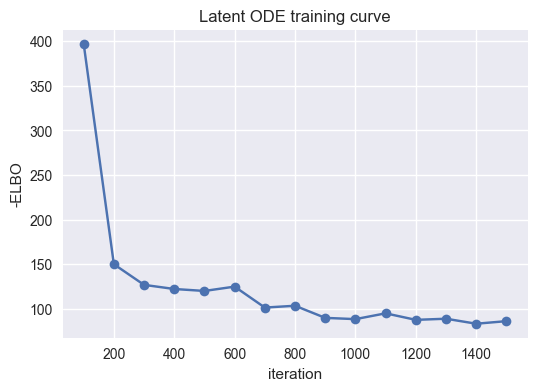

In [14]:
plt.figure()
plt.plot(training_log['iters'], training_log['losses'], marker='o')
plt.xlabel('iteration')
plt.ylabel('-ELBO')
plt.title('Latent ODE training curve')
plt.show()


## 9. Posterior sampling & reconstruction
We draw $z_0 \sim q(z_0 \mid x)$, integrate both forward and backward in time, and decode to observation space to illustrate interpolation/extrapolation just like Fig. 3 in the paper.


In [15]:
def posterior_sample(model, obs_seq, t_obs, t_full_pos, t_full_neg):
    model.eval()
    with torch.no_grad():
        q_mean, q_logvar = model.encoder(obs_seq)
        z0 = q_mean[0]
        solver = odeint_adjoint if model.use_adjoint else odeint
        z_pos = solver(model.func, z0, t_full_pos, method=model.solver,
                       rtol=model.rtol, atol=model.atol)
        z_neg = solver(model.func, z0, t_full_neg, method=model.solver,
                       rtol=model.rtol, atol=model.atol)
        x_pos = model.decoder(z_pos)
        x_neg = model.decoder(z_neg)
    return x_pos.cpu(), x_neg.cpu()

long_ts_pos = torch.linspace(0.0, 2 * np.pi, 2000, device=DEVICE)
long_ts_neg = torch.linspace(-np.pi, 0.0, 1000, device=DEVICE)
x_pos, x_neg = posterior_sample(latent_model, samp_trajs, samp_ts, long_ts_pos, long_ts_neg)


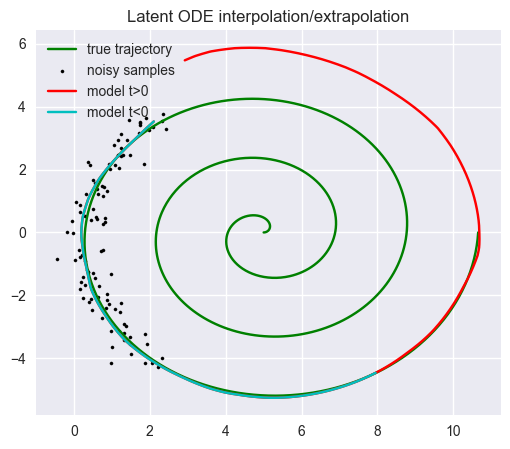

In [16]:
def plot_latent_recon(orig, samples, pos, neg):
    orig_np = orig[0].cpu().numpy()
    samp_np = samples[0].cpu().numpy()
    pos_np = pos.numpy()
    neg_np = torch.flip(neg, dims=[0]).numpy()
    plt.figure(figsize=(6, 5))
    plt.plot(orig_np[:, 0], orig_np[:, 1], 'g', label='true trajectory')
    plt.scatter(samp_np[:, 0], samp_np[:, 1], s=5, c='k', label='noisy samples')
    plt.plot(pos_np[:, 0], pos_np[:, 1], 'r', label='model t>0')
    plt.plot(neg_np[:, 0], neg_np[:, 1], 'c', label='model t<0')
    plt.legend()
    plt.title('Latent ODE interpolation/extrapolation')
    plt.show()

plot_latent_recon(orig_trajs, samp_trajs, x_pos, x_neg)


## 10. Handling irregular timestamps
Because `odeint` accepts arbitrary evaluation grids, we can subsample random timestamps per trajectory. The encoder only sees available points; the decoder still generates a dense trajectory at `samp_ts`.


In [17]:
def random_time_mask(data, drop_prob=0.3):
    mask = torch.rand_like(data[..., 0]) > drop_prob
    masked = data.clone()
    masked[~mask] = 0.0
    return masked, mask

masked_obs, mask = random_time_mask(samp_trajs, drop_prob=0.5)
masked_loss = latent_model.elbo(masked_obs, samp_ts)
print('ELBO with 50% missing points:', masked_loss.item())


ELBO with 50% missing points: 9372.71484375


## 11. Exercises
- **Adjoint vs. standard backprop:** set `use_adjoint=True` to reduce memory and compare wall-clock time.
- **Noisy or irregular batches:** sample a different timestamp mask per iteration to mimic ICU data from Section 5.
- **Latent dimension sweep:** try latent dimensions {4, 8, 16} and report ELBO / reconstruction quality.
- **VAE diagnostics:** track $\mathrm{KL}$ separately to monitor posterior collapse, similar to Appendix C of the paper.

These prompts match the style of other course sections and encourage deeper experimentation.
